In [30]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import *     # Import all the preprocessing methods
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, balanced_accuracy_score, accuracy_score, precision_recall_curve, average_precision_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import numpy as np
import sys
from sklearn.model_selection import train_test_split, TimeSeriesSplit
plt.rcParams["figure.figsize"] = (12,10)

import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
train_set = pd.read_csv('./data/train_df_expanded_KNN_imp.csv')
train_set = train_set.replace([np.inf, -np.inf], np.nan)

In [3]:
train_set.head(2)

,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_WBTbgPs_psi,Avg_VW1_WBTbgTp_F,Avg_VW1_ANPs_psi,Avg_VW1_Z11D4917Ps_psi,...,Diff pressure downhole-wellhead_lag5,Diff pressure downhole-wellhead_pct_change5,Diff pressure downhole-wellhead_diff5,Date,window_start,window_duration,within_window,Target,Abs Target,Target > 2
0,20.543221,0.745443,43.628174,89.604440,2893.751821,116.538303,2173.683197,104.050357,1599.975952,2073.024188,...,2803.968286,0.000064,0.179096,2009-10-01 06:00:00,0,0,0,0.0,0.0,0
1,20.543221,0.558594,41.564208,89.435158,2893.744224,116.537717,2173.705924,104.058877,1599.975952,2073.052203,...,2803.984752,0.000116,0.324314,2009-10-01 07:00:00,0,0,0,0.0,0.0,0


In [21]:
y_train = train_set['Target']
x_train = train_set.drop(['Date', 'window_start', 'window_duration', 'within_window', 'Target', 'Abs Target', 'Target > 2'], axis=1)

In [22]:
def xgb_mape(preds, dtrain):
   labels = dtrain.get_label()
   return('mape', -np.mean(np.abs((labels - preds) / (labels + 1))))

params = {'alpha': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'eta': 0.05, 'eval_metric': ['rmse'],
          'lambda': 1, 'max_depth': 4, 'objective': 'reg:squarederror', 'scale_pos_weight': 1, 'subsample': 0.7, 'tree_method': 'exact',
          'nthread': -2, 'base_score': 0}

In [23]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.33, shuffle=False)

In [24]:
dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_test, y_test)

In [25]:
clf = xgb.train(params,dtrain,evals=[(dtrain, 'train'),(dval, 'test')],num_boost_round=180,verbose_eval=True,early_stopping_rounds=10)

[0]	train-rmse:3.64426	test-rmse:3.65852
[1]	train-rmse:3.52926	test-rmse:3.50739
[2]	train-rmse:3.41532	test-rmse:3.34887
[3]	train-rmse:3.30969	test-rmse:3.24182
[4]	train-rmse:3.21322	test-rmse:3.13410
[5]	train-rmse:3.11837	test-rmse:3.02081
[6]	train-rmse:3.02893	test-rmse:2.93051
[7]	train-rmse:2.94220	test-rmse:2.82288
[8]	train-rmse:2.86351	test-rmse:2.74858
[9]	train-rmse:2.79107	test-rmse:2.65463
[10]	train-rmse:2.71401	test-rmse:2.56419
[11]	train-rmse:2.64813	test-rmse:2.49626
[12]	train-rmse:2.58375	test-rmse:2.44003
[13]	train-rmse:2.52452	test-rmse:2.40788
[14]	train-rmse:2.46610	test-rmse:2.34286
[15]	train-rmse:2.41247	test-rmse:2.27896
[16]	train-rmse:2.36215	test-rmse:2.23799
[17]	train-rmse:2.31348	test-rmse:2.20231
[18]	train-rmse:2.27070	test-rmse:2.17116
[19]	train-rmse:2.22712	test-rmse:2.11862
[20]	train-rmse:2.19143	test-rmse:2.06263
[21]	train-rmse:2.15368	test-rmse:2.03981
[22]	train-rmse:2.11535	test-rmse:1.99881
[23]	train-rmse:2.07710	test-rmse:1.96774
[2

In [26]:
y_pred_train = clf.predict(dtrain)
y_pred_val = clf.predict(dval)

In [28]:
# calculate and print the RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_val))
mape = mean_absolute_percentage_error(y_test, y_pred_val) * 100
print('RMSE: {:.2f}'.format(rmse))
print('MAPE: {:.2f}%'.format(mape))

RMSE: 1.70
MAPE: 13780666143547302.00%


In [37]:
def weighted_mape(y_true, y_pred, w):
    """Calculate the weighted MAPE of a regression model."""
    eps = 1e-8  # a small epsilon value to avoid divide-by-zero errors
    ape = np.abs((y_true - y_pred) / (y_true + eps))
    return np.average(ape, weights=w) * 100

# calculate the weighted MAPE
w = y_test/sum(y_test) # assume 'weight' is a column in the test set
wmape = weighted_mape(y_test, y_pred_val, w)
print('Weighted MAPE: {:.2f}%'.format(wmape))

Weighted MAPE: 28472.12%


In [38]:

mean_absolute_percentage_error(y_test, y_pred_val, sample_weight=y_test/sum(y_test), multioutput='uniform_average')


284.7208165301643

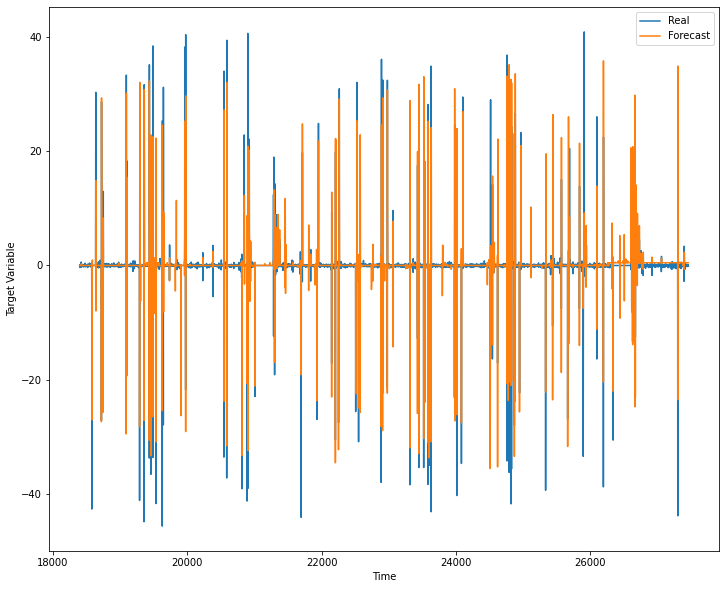

In [31]:
# plot the forecasted values against the real values
plt.plot(y_test.index, y_test.values, label='Real')
plt.plot(y_test.index, y_pred_val, label='Forecast')
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

## NOT USED

In [ ]:
int(np.ceil(optimal_num_trees))

In [16]:
feature_list = list(x_train.columns)
best_features = []
train_aucs = []
train_aucs_std = []
val_aucs = []
val_aucs_std = []
test_aucs = []
train_logloss = []
train_logloss_std = []
val_logloss = []
val_logloss_std = []
test_logloss = []

while len(feature_list)>1:

    for feature in feature_list:

        feature_dict = {}

        temp_train = x_train[best_features+[feature]]
        dtrain = xgb.DMatrix(temp_train, y_train)

        # CROSS VALIDATION
        
        xgb_cv = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,  # Maximum iterations
        nfold=4, # Number of folds to use
        metrics=['auc','logloss'], # List of evaluation metrics to be used in cross validation, when it is not specified, the evaluation metric is chosen according to objective function.
        as_pandas=False,
        seed=42,
        stratified=True,
        early_stopping_rounds=10, # Training with a validation set will stop if the performance doesn't improve for n rounds.
        )

        loglosses_train = np.round(xgb_cv['train-logloss-mean'][-1],4)
        loglosses_train_std = np.round(xgb_cv['train-logloss-std'][-1],4)
        loglosses_val = np.round(xgb_cv['test-logloss-mean'][-1],4)
        loglosses_val_std = np.round(xgb_cv['test-logloss-std'][-1],4)
        auc_train = np.round(xgb_cv['train-auc-mean'][-1],4)
        auc_train_std = np.round(xgb_cv['train-auc-std'][-1],4)
        auc_val = np.round(xgb_cv['test-auc-mean'][-1],4)
        auc_val_std = np.round(xgb_cv['test-auc-std'][-1],4)
                
        feature_dict[feature] = [loglosses_val, loglosses_val_std, loglosses_train, loglosses_train_std,
                                auc_val, auc_val_std, auc_train, auc_train_std]

        
        best_feature = min((feature_dict[key][0],key) for key in feature_dict)[1]

    # TEST

    temp_test = x_test[best_features+[feature]]
    dtest = xgb.DMatrix(temp_test, y_test)

    clf = xgb.XGBClassifier(**params)
    clf.set_params(n_estimators=len(xgb_cv['test-auc-std'])+int(np.log(len(xgb_cv['test-auc-std'])))+2)
    clf = clf.fit(x_train[best_features+[feature]], y_train)
    # pred = clf.predict_proba(x_test)[:,1]

    # fpr, tpr, thresholds = roc_curve(y_test, pred)
    # test_auc = auc(fpr, tpr)
    pred = clf.predict(temp_test)
    test_auc = accuracy_score(y_test, pred)
    test_log = log_loss(y_test, clf.predict_proba(temp_test), labels=[0, 1])


    print('\n')
    print('*****'*5)
    best_features.append(best_feature)
    print(f'Best features so far: {best_features} \n Train mean logloss: {feature_dict[best_feature][2]:.4f} +/- {feature_dict[best_feature][3]:.4f}  \n Val mean logloss: {feature_dict[best_feature][0]:.4f} +/- {feature_dict[best_feature][1]:.4f}')
    print(f' Train mean auc: {feature_dict[best_feature][6]:.4f} +/- {feature_dict[best_feature][7]:.4f}  \n Val mean auc: {feature_dict[best_feature][4]:.4f} +/- {feature_dict[best_feature][5]:.4f}')
    print(f'Test auc: {test_auc:.4f}')
    print(len(best_features))
    print(len(feature_list))

    train_aucs.append(feature_dict[best_feature][6])
    train_aucs_std.append(feature_dict[best_feature][7])
    val_aucs.append(feature_dict[best_feature][4])
    val_aucs_std.append(feature_dict[best_feature][5])
    test_aucs.append(test_auc)

    train_logloss.append(feature_dict[best_feature][2])
    train_logloss_std.append(feature_dict[best_feature][3])
    val_logloss.append(feature_dict[best_feature][0])
    val_logloss_std.append(feature_dict[best_feature][1])
    test_logloss.append(test_log)


    # Remove best feature from list of features
    feature_list.remove(best_feature)



*************************
Best features so far: ['is_blending'] 
 Train mean logloss: 0.6016 +/- 0.0049  
 Val mean logloss: 0.6088 +/- 0.0116
 Train mean auc: 0.5457 +/- 0.0238  
 Val mean auc: 0.5466 +/- 0.0717
Test auc: 1.0000
1
79


*************************
Best features so far: ['is_blending', 'SpinGap'] 
 Train mean logloss: 0.5510 +/- 0.0112  
 Val mean logloss: 0.5739 +/- 0.0256
 Train mean auc: 0.7145 +/- 0.0319  
 Val mean auc: 0.6647 +/- 0.1022
Test auc: 1.0000
2
78


*************************
Best features so far: ['is_blending', 'SpinGap', 'N2_FI_std'] 
 Train mean logloss: 0.4595 +/- 0.0185  
 Val mean logloss: 0.5475 +/- 0.0375
 Train mean auc: 0.8673 +/- 0.0154  
 Val mean auc: 0.7242 +/- 0.0648
Test auc: 1.0000
3
77


*************************
Best features so far: ['is_blending', 'SpinGap', 'N2_FI_std', 'N2_FI_ave'] 
 Train mean logloss: 0.3585 +/- 0.0164  
 Val mean logloss: 0.4962 +/- 0.0415
 Train mean auc: 0.9462 +/- 0.0065  
 Val mean auc: 0.7849 +/- 0.0632
Te

In [22]:
x = [i for i in range(len(train_aucs_std))]

In [23]:
plt.rcParams["figure.figsize"] = (12,8)

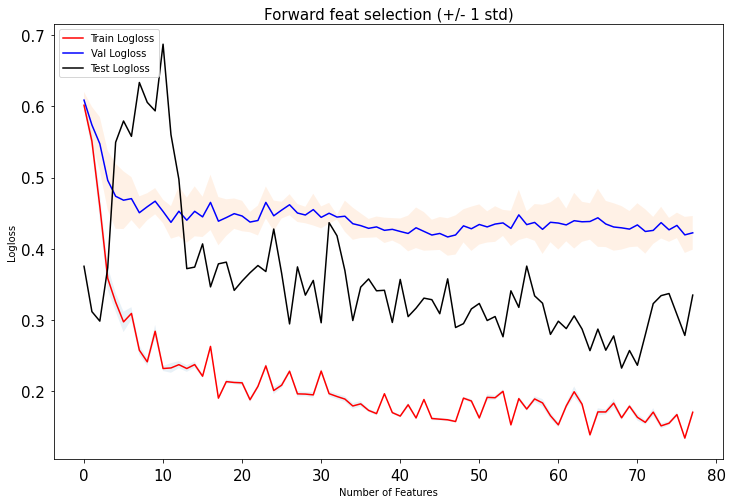

In [24]:
plt.plot(x, train_logloss, 'r', label='Train Logloss')
plt.fill_between(x, np.array(train_logloss)-np.array(train_logloss_std), np.array(train_logloss)+np.array(train_logloss_std), alpha=.1)
plt.plot(x, val_logloss, 'b', label='Val Logloss')
plt.fill_between(x, np.array(val_logloss)-np.array(val_logloss_std), np.array(val_logloss)+np.array(val_logloss_std), alpha=.1)
plt.plot(x, test_logloss, 'k', label='Test Logloss')
plt.xlabel('Number of Features')
plt.ylabel('Logloss')
plt.tick_params(axis='both', labelsize=15, pad=5)
plt.title('Forward feat selection (+/- 1 std)', fontsize=15)
plt.legend(loc='upper left');

In [27]:
val_logloss[np.argmin(val_logloss)]

0.4167

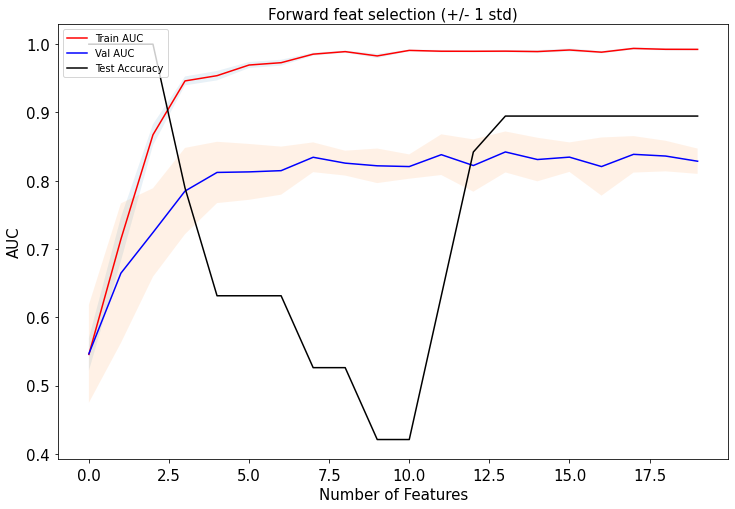

In [35]:
plt.plot(x[:20], train_aucs[:20], 'r', label='Train AUC')
plt.fill_between(x[:20], np.array(train_aucs[:20])-np.array(train_aucs_std[:20]), np.array(train_aucs[:20])+np.array(train_aucs_std[:20]), alpha=.1)
plt.plot(x[:20], val_aucs[:20], 'b', label='Val AUC')
plt.fill_between(x[:20], np.array(val_aucs[:20])-np.array(val_aucs_std[:20]), np.array(val_aucs[:20])+np.array(val_aucs_std[:20]), alpha=.1)
plt.xlabel('Number of Features', fontsize=15)
plt.plot(x[:20], test_aucs[:20], 'k', label='Test Accuracy')
plt.ylabel('AUC', fontsize=15)
plt.tick_params(axis='both', labelsize=15, pad=5)
plt.title('Forward feat selection (+/- 1 std)', fontsize=15)
plt.legend(loc='upper left');

In [29]:
val_aucs[np.argmax(val_aucs)]

0.8597

In [30]:
np.argmax(val_aucs)

45

In [34]:
feat = best_features[:np.argmax(val_aucs)]

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

xgb_cv = xgb.cv(
  params=params,
  dtrain=dtrain,
  num_boost_round=1000,  # Maximum iterations
  nfold=4, # Number of folds to use
  metrics=['auc','logloss'], # List of evaluation metrics to be used in cross validation, when it is not specified, the evaluation metric is chosen according to objective function.
  as_pandas=True,
  seed=41,
  stratified=True,
  early_stopping_rounds=10, # Training with a validation set will stop if the performance doesn't improve for n rounds.
)

xgb_cv

,train-auc-mean,train-auc-std,train-logloss-mean,train-logloss-std,test-auc-mean,test-auc-std,test-logloss-mean,test-logloss-std
0,0.835403,0.041317,0.670746,0.001551,0.724488,0.047550,0.676034,0.001915
1,0.899189,0.029542,0.649445,0.002909,0.773181,0.044666,0.661422,0.003503
2,0.935126,0.014960,0.631832,0.004322,0.783098,0.066852,0.649962,0.005821
3,0.952386,0.009281,0.614010,0.003323,0.767877,0.055257,0.640722,0.007511
4,0.961504,0.015102,0.597163,0.004452,0.785689,0.062876,0.629870,0.008974
...,...,...,...,...,...,...,...,...
117,0.999934,0.000081,0.148954,0.007743,0.855214,0.061223,0.418612,0.061879
118,0.999934,0.000081,0.147965,0.007630,0.854045,0.061411,0.418546,0.061524
119,0.999934,0.000081,0.146935,0.007344,0.853752,0.061459,0.418148,0.061224
120,0.999934,0.000081,0.145836,0.007245,0.853135,0.060759,0.418108,0.061759
